In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt
import time
import importlib
import stormcoupling as sc
import glob
from scipy import stats
import scipy
from geopy import distance
from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import xlrd
import csv
import os
import math
import matplotlib.colors
import metpy
from metpy.interpolate import interpolate_to_isosurface
from metpy.calc import dewpoint_from_specific_humidity
from metpy.calc import equivalent_potential_temperature
from matplotlib.ticker import LogFormatterSciNotation
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from metpy.units import units 
import metpy.calc as mpcalc
importlib.reload(sc)

<module 'stormcoupling' from '/lustre06/project/6084782/shared/gabe-fall-2025/TEtracking/stormcoupling.py'>

In [2]:
def parse_te_tracks(filename):
    tracks = []
    trackid = -1
    with open(filename) as f:
        current_id = None
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            if parts[0] == "start":
                length = int(parts[1])  # track ID
                trackid = trackid+1
            else:
                lon, lat, msl, year, month, day, hour = parts[-7:]
                tracks.append({
                    "id": trackid,
                    "length": length,
                    "lon": float(lon),
                    "lat": float(lat),
                    "msl": float(msl),
                    "time": pd.Timestamp(int(year), int(month), int(day), int(hour))
                })
    return pd.DataFrame(tracks)

In [3]:
df = parse_te_tracks("data/TEtextfiles/StitchNodes/cyclone_SN_msl.txt")

In [15]:
df

,id,length,lon,lat,msl,time
0,0,15,-52.00,66.25,97223.94,2015-01-01 00:00:00
1,0,15,-54.00,68.50,97348.31,2015-01-01 03:00:00
2,0,15,-54.00,69.75,97403.12,2015-01-01 06:00:00
3,0,15,-55.25,70.50,97654.69,2015-01-01 09:00:00
4,0,15,-56.75,70.75,97946.62,2015-01-01 12:00:00
...,...,...,...,...,...,...
5347,228,21,-53.25,46.25,98470.31,2015-04-28 06:00:00
5348,228,21,-54.50,46.75,98573.00,2015-04-28 09:00:00
5349,228,21,-56.75,47.00,98826.06,2015-04-28 12:00:00
5350,228,21,-59.50,46.75,98935.69,2015-04-28 15:00:00


In [38]:
defaultSYN = '/home/glach/projects/def-rfajber/shared/tracks-gabe/SYN_Tracks.csv'
syns = pd.read_csv(defaultSYN)

fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in df.groupby("id"):
    axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(1 <= month <= 4):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[1].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (just msl)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [4]:
msl_200_vo = parse_te_tracks("data/TEtextfiles/StitchNodes/cyclone_SN.txt")

In [33]:
msl_200_vo[msl_200_vo['id'] == 28]

,id,length,lon,lat,msl,time
612,28,54,-115.00,59.25,100680.20,2015-01-14 06:00:00
613,28,54,-112.00,57.75,100653.90,2015-01-14 09:00:00
614,28,54,-110.75,56.25,100654.90,2015-01-14 12:00:00
615,28,54,-109.00,55.75,100648.50,2015-01-14 15:00:00
616,28,54,-104.25,54.25,100645.30,2015-01-14 18:00:00
617,28,54,-101.75,53.25,100575.40,2015-01-14 21:00:00
618,28,54,-98.50,52.75,100638.30,2015-01-15 00:00:00
619,28,54,-96.25,52.75,100575.90,2015-01-15 03:00:00
620,28,54,-93.50,52.25,100401.20,2015-01-15 06:00:00
621,28,54,-89.75,52.00,100225.10,2015-01-15 09:00:00


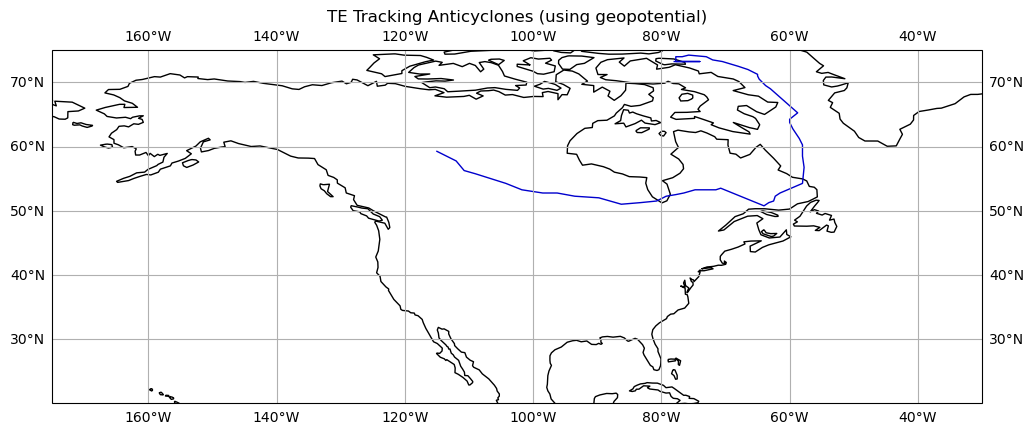

In [30]:
## uses geopotential data, didnt work

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in msl_200_vo.groupby("id"):
    if(tid == 28):
        ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('TE Tracking Anticyclones (using geopotential)')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

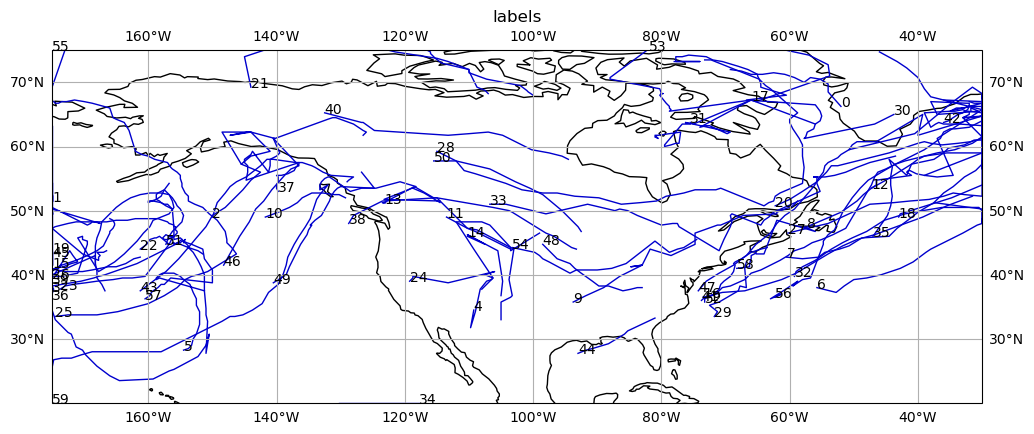

In [28]:

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in msl_200_vo.groupby("id"):
    if(int(track.time.iloc[0].month) == 1):
        ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
        ax.text(track["lon"][track.index[0]], track["lat"][track.index[0]], f'{tid}', transform=ccrs.PlateCarree())
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('labels')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [26]:
msl_200_vo

,id,length,lon,lat,msl,time
0,0,15,-52.00,66.25,97223.94,2015-01-01 00:00:00
1,0,15,-54.00,68.50,97348.31,2015-01-01 03:00:00
2,0,15,-54.00,69.75,97403.12,2015-01-01 06:00:00
3,0,15,-55.25,70.50,97654.69,2015-01-01 09:00:00
4,0,15,-56.75,70.75,97946.62,2015-01-01 12:00:00
...,...,...,...,...,...,...
5237,227,21,-53.25,46.25,98470.31,2015-04-28 06:00:00
5238,227,21,-54.50,46.75,98573.00,2015-04-28 09:00:00
5239,227,21,-56.75,47.00,98826.06,2015-04-28 12:00:00
5240,227,21,-59.50,46.75,98935.69,2015-04-28 15:00:00


In [5]:
msl_200_vo

,id,length,lon,lat,msl,time
0,0,15,-52.00,66.25,97223.94,2015-01-01 00:00:00
1,0,15,-54.00,68.50,97348.31,2015-01-01 03:00:00
2,0,15,-54.00,69.75,97403.12,2015-01-01 06:00:00
3,0,15,-55.25,70.50,97654.69,2015-01-01 09:00:00
4,0,15,-56.75,70.75,97946.62,2015-01-01 12:00:00
...,...,...,...,...,...,...
5237,227,21,-53.25,46.25,98470.31,2015-04-28 06:00:00
5238,227,21,-54.50,46.75,98573.00,2015-04-28 09:00:00
5239,227,21,-56.75,47.00,98826.06,2015-04-28 12:00:00
5240,227,21,-59.50,46.75,98935.69,2015-04-28 15:00:00


In [18]:
track.index[0]

15

In [25]:
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in msl_200_vo.groupby("id"):
    axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
    axes[0].text(track["lon"][track.index[0]], track["lat"][track.index[0]], f'{tid}', transform=ccrs.PlateCarree())
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(1 <= month <= 4):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[1].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (msl + 700mb vo)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x153b9798e160> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

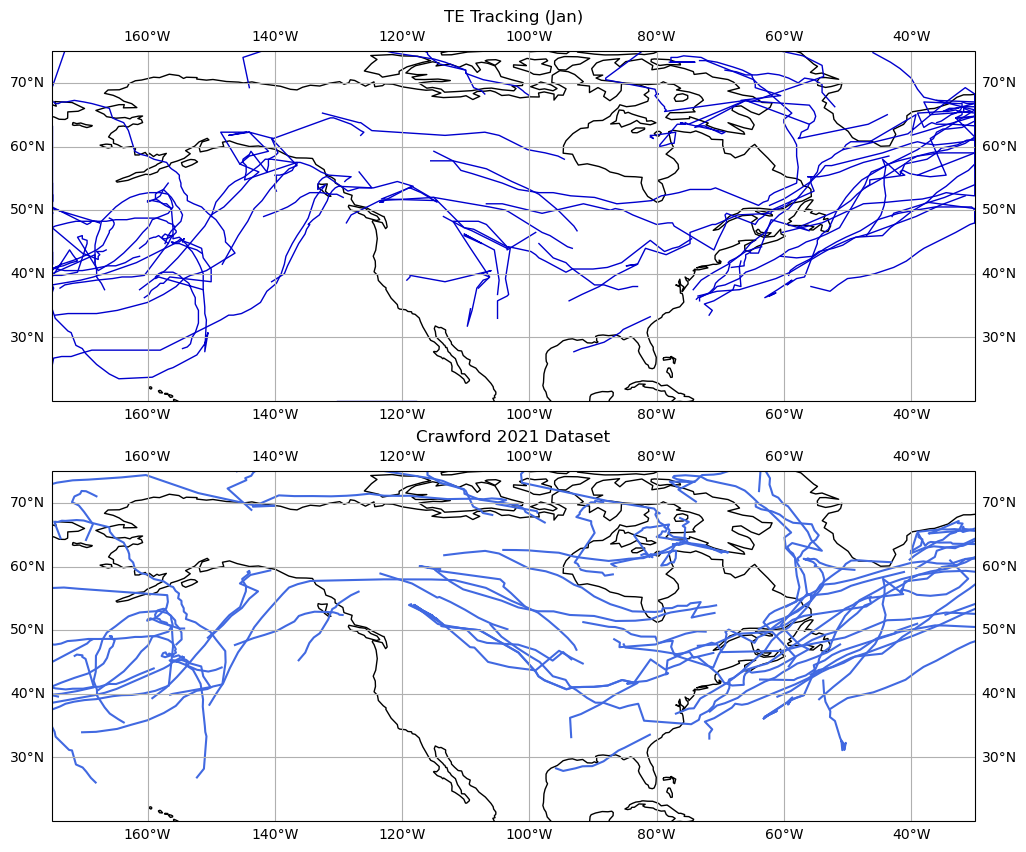

In [36]:
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in msl_200_vo.groupby("id"):
    if(int(track.time.iloc[0].month) == 1):
        axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(month == 1):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[1].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (Jan)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

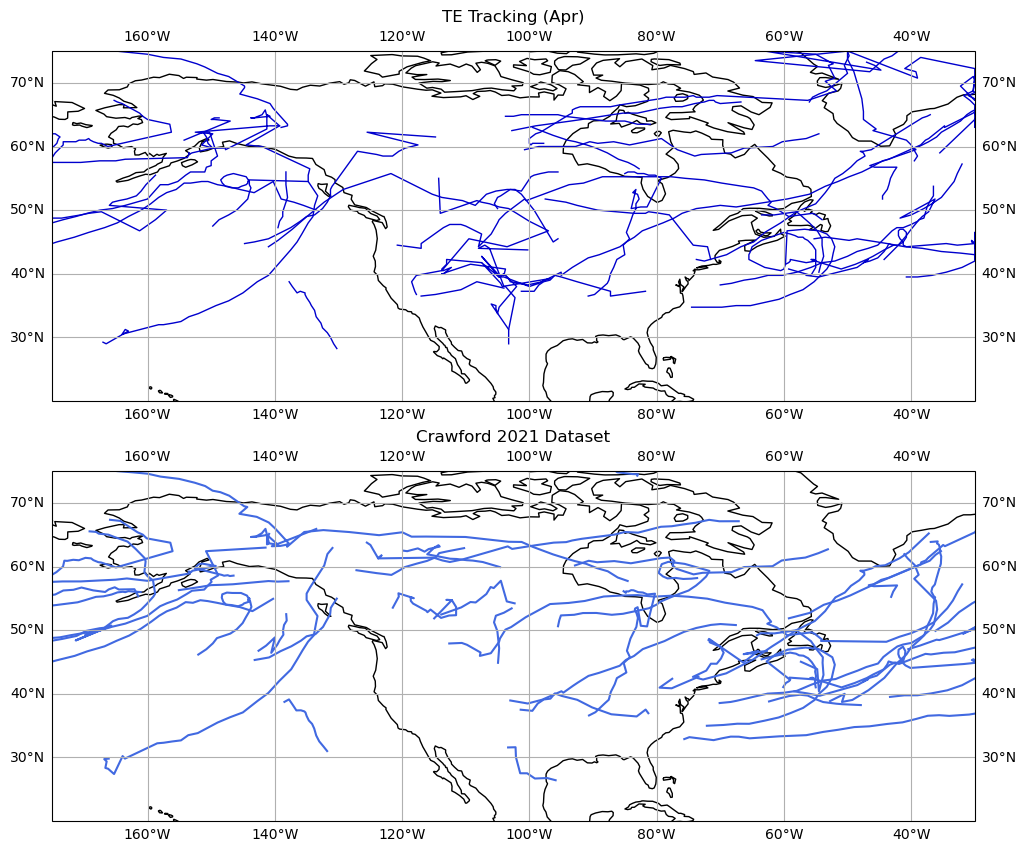

In [55]:
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in msl_200_vo.groupby("id"):
    if(int(track.time.iloc[0].month) == 4):
        axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(month == 4):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[1].set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (Apr)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [56]:
df_ac = parse_te_tracks('anticyclone_SN.txt')

In [57]:
df_ac

,id,length,lon,lat,msl,time
0,0,22,-30.00,70.25,100001.70,2015-01-01 00:00:00
1,0,22,-30.00,70.25,100016.80,2015-01-01 03:00:00
2,0,22,-30.00,70.25,100003.60,2015-01-01 06:00:00
3,0,22,-30.00,70.25,99970.69,2015-01-01 09:00:00
4,0,22,-30.00,70.25,99974.38,2015-01-01 12:00:00
...,...,...,...,...,...,...
1407,72,12,-171.00,75.00,101807.00,2015-04-30 06:00:00
1408,72,12,-171.00,75.00,101943.40,2015-04-30 09:00:00
1409,72,12,-171.00,75.00,102049.90,2015-04-30 12:00:00
1410,72,12,-171.75,75.00,102142.10,2015-04-30 15:00:00


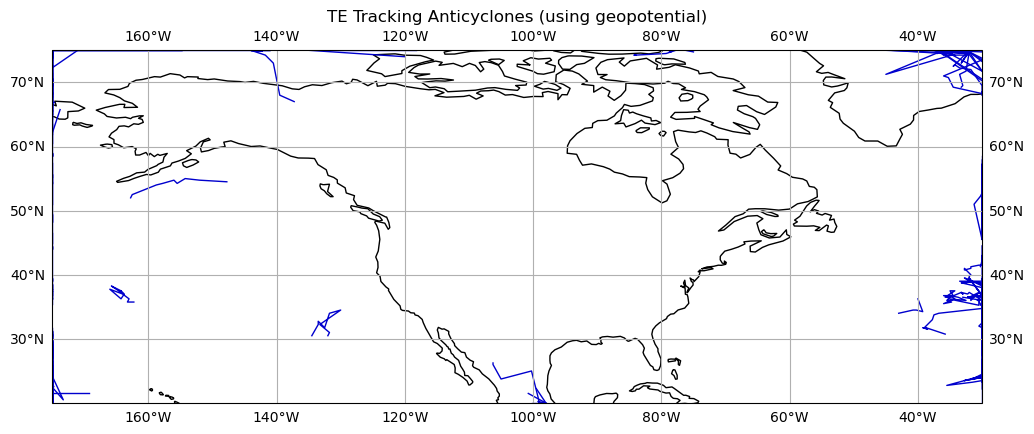

In [58]:
## uses geopotential data, didnt work

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in df_ac.groupby("id"):
    ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('TE Tracking Anticyclones (using geopotential)')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [59]:
df_ac_2 = parse_te_tracks('anticyclone_SN_2.txt')

In [60]:
df_ac_2

,id,length,lon,lat,msl,time
0,0,46,-175.00,75.00,102815.7,2015-01-01 00:00:00
1,0,46,-152.25,75.00,104091.8,2015-01-01 03:00:00
2,0,46,-150.00,75.00,104133.9,2015-01-01 06:00:00
3,0,46,-147.00,75.00,104097.2,2015-01-01 09:00:00
4,0,46,-148.00,75.00,104162.9,2015-01-01 12:00:00
...,...,...,...,...,...,...
9394,525,3,-30.00,28.75,102246.1,2015-04-30 15:00:00
9395,526,4,-68.75,33.75,100797.4,2015-04-30 12:00:00
9396,526,4,-67.75,33.50,100862.4,2015-04-30 15:00:00
9397,526,4,-66.00,33.25,100856.9,2015-04-30 18:00:00


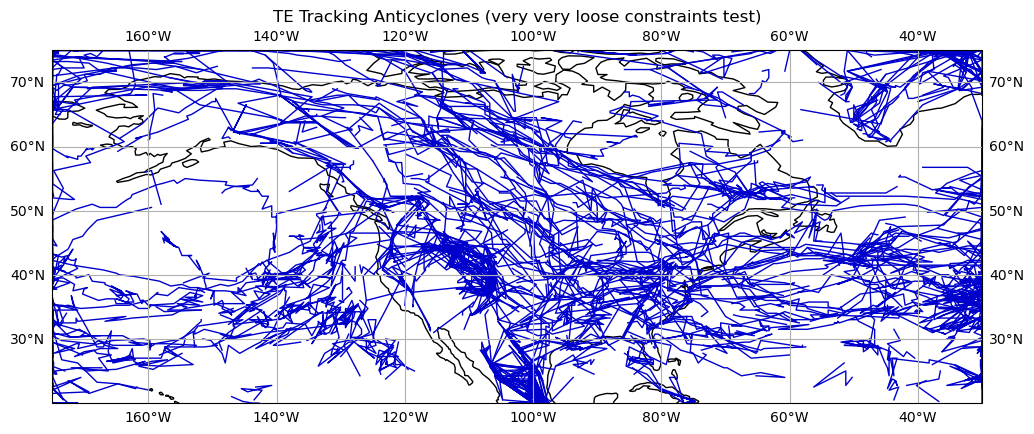

In [61]:
## very loose, 75Pa pressure decrease within 12 degrees
## no geopotential data

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in df_ac_2.groupby("id"):
    ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('TE Tracking Anticyclones (very very loose constraints test)')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [6]:
df_ac_3 = parse_te_tracks('data/TEtextfiles/StitchNodes/anticyclone_SN_3.txt')

In [7]:
df_ac_3

,id,length,lon,lat,msl,time
0,0,46,-175.00,75.00,102815.7,2015-01-01 00:00:00
1,0,46,-152.25,75.00,104091.8,2015-01-01 03:00:00
2,0,46,-150.00,75.00,104133.9,2015-01-01 06:00:00
3,0,46,-147.00,75.00,104097.2,2015-01-01 09:00:00
4,0,46,-148.00,75.00,104162.9,2015-01-01 12:00:00
...,...,...,...,...,...,...
3249,116,6,-100.00,24.75,101894.5,2015-04-30 03:00:00
3250,116,6,-100.25,24.75,101865.8,2015-04-30 06:00:00
3251,116,6,-100.00,24.25,101734.7,2015-04-30 09:00:00
3252,116,6,-100.50,23.75,101769.6,2015-04-30 12:00:00


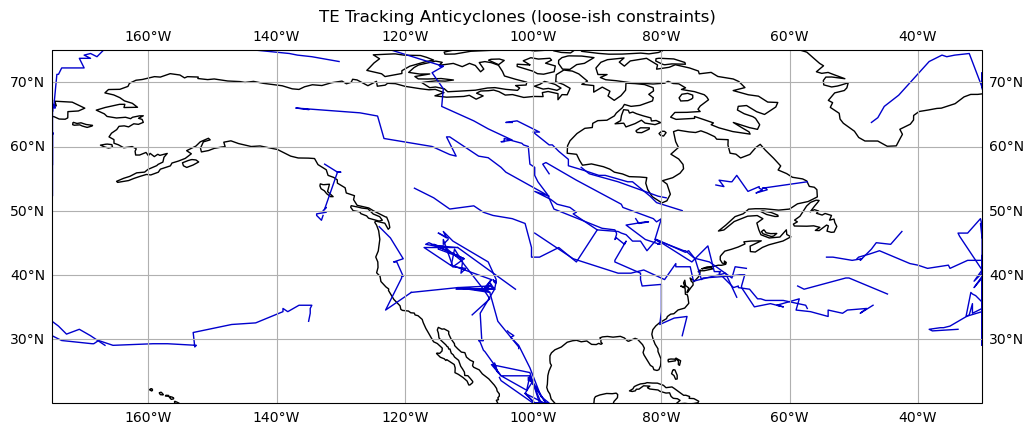

In [12]:
## 150 Pa decrease within 8 degrees
## Stricter stitchnodes

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
# Plot each cyclone track
for tid, track in df_ac_3.groupby("id"):
    if(int(track.time.iloc[0].month) == 3):
        ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('TE Tracking Anticyclones (loose-ish constraints)')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show() 

In [ ]:
## only 27 tracks found with 400 Pa contour

In [4]:
df_ac_4 = parse_te_tracks('anticyclone_SN_5.txt')

In [6]:
df_ac_4

,id,length,lon,lat,msl,time
0,0,11,-30.00,45.25,102908.4,2015-01-01 18:00:00
1,0,11,-30.00,45.25,103000.3,2015-01-01 21:00:00
2,0,11,-30.00,46.00,102940.9,2015-01-02 00:00:00
3,0,11,-30.00,46.50,102644.8,2015-01-02 03:00:00
4,0,11,-30.00,50.25,102518.2,2015-01-02 06:00:00
...,...,...,...,...,...,...
1594,76,6,-103.75,44.25,102873.9,2015-04-28 03:00:00
1595,76,6,-105.50,41.75,102928.3,2015-04-28 06:00:00
1596,76,6,-105.25,37.00,102955.8,2015-04-28 12:00:00
1597,76,6,-109.25,33.75,102173.1,2015-04-29 00:00:00


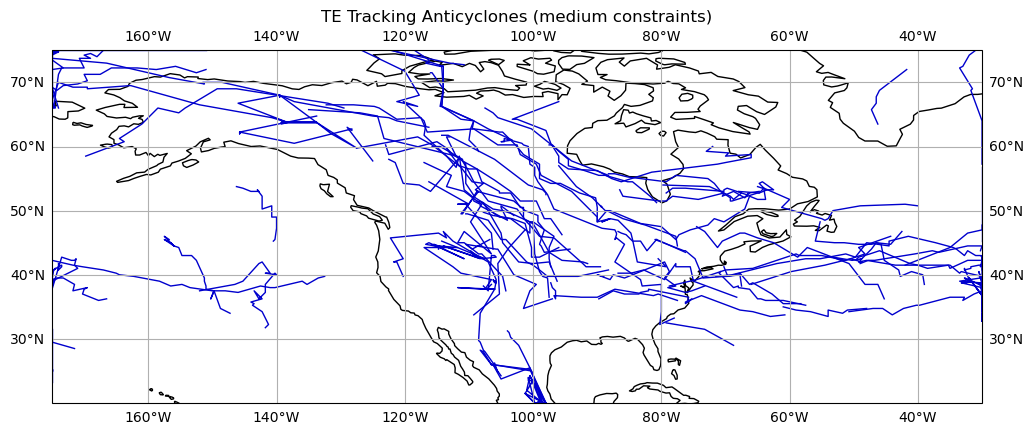

In [7]:
## 250 Pa decrease within 8 degrees
## Stricter stitchnodes

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in df_ac_4.groupby("id"):
    ax.plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
ax.set_extent([-175, -30, 20, 75], crs=ccrs.PlateCarree())
ax.set_title('TE Tracking Anticyclones (medium constraints)')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()